# Mean radius and sizes thresholds calculation

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import yaml

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, peak_widths


from endoanalysis.nucprop import NucleiPropagator
from endoanalysis.datasets import PointsDataset
from endoanalysis.utils import load_masks_areas, decorate_areas_distr

In [2]:
MASKS_DIR = "../masks/"
IMGS_DIR = "figs"
YAML_PATH = "../data/radius_and_threshs.yml"

Cheking the imported masks

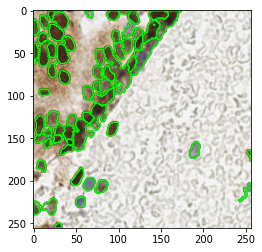

In [5]:
image_path ="../data/Dataset/Images/Bulk/Pathologists/101.png"

masks_path = os.path.join(MASKS_DIR, "101.npz")
with open(masks_path, "rb") as file:
    masks = np.load(file)["masks"]
image = cv2.imread(image_path)[:,:,::-1]
propagator = NucleiPropagator(window_size=100) 
propagator.visualise_masks(image, masks=masks)

Importing the masks

In [8]:
paths_list = [os.path.join(MASKS_DIR, x) for x in os.listdir(MASKS_DIR) if x.endswith(".npz")]
mask_areas = load_masks_areas(paths_list)

Loading mask areas: 100%|██████████| 1390/1390 [00:26<00:00, 51.94it/s]

Done!


The raw distribution

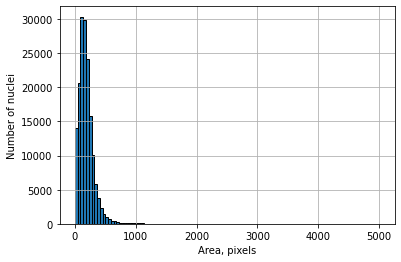

In [9]:
fig, ax = plt.subplots()
_ = ax.hist(mask_areas, bins="rice", edgecolor="black")
decorate_areas_distr(fig, ax, impath=os.path.join(IMGS_DIR, "raw_areas_distr"))

It seems that there are some outliers in the right tail. Let's take a closer look:


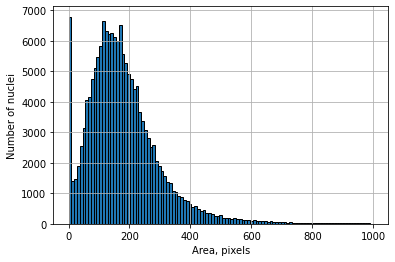

In [10]:
cut_value = 1000
mask_areas_cut = mask_areas[mask_areas<cut_value]

fig, ax = plt.subplots()
hist, bins, _ = ax.hist(mask_areas_cut, edgecolor='black', bins="rice")
bin_width = bins[1] - bins[0]
kde = gaussian_filter1d(hist, sigma=bin_width/4)
centers = (bins[1:] + bins[:-1]) / 2
peaks = find_peaks(kde)[0]
decorate_areas_distr(fig, ax, impath=os.path.join(IMGS_DIR, "cut_areas_distr"))


We can see, that there are also outliers at smal area values. We treat big and small outliers separately

Main peak is at 132 pixels.


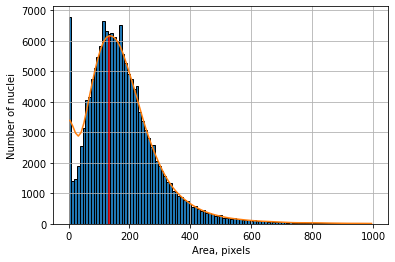

In [11]:
peaks = find_peaks(kde)[0]
main_peak_bin_id = peaks[0]
main_peak = centers[main_peak_bin_id]
fig, ax = plt.subplots()
hist, bins, _ = ax.hist(mask_areas_cut, edgecolor='black', bins="rice")
ax.plot(centers, kde)
ax.vlines(centers[peaks], 0, kde[main_peak_bin_id], colors=["r"])
decorate_areas_distr(fig, ax)
print("Main peak is at %i pixels."%main_peak)

Now lets set the threshold for outliers with big areas. We define it as 0.99 right quantile (stating from the main peak):

In [12]:
fraction = 0.99
size = 100
hist_right = hist[main_peak_bin_id:]
bins_right = bins[main_peak_bin_id:]
integral = np.sum(np.tril(np.repeat(hist_right.reshape(1,-1), size,axis=0)), axis=1)
full_integral = integral[-1]
thresh_bin_id = np.min(np.where(integral > full_integral * fraction)[0])
thresh_big = bins_right[thresh_bin_id]
print("The threshold for outliers with big ares is %1.2f pixels."%np.round(thresh_big))


The threshold for outliers with big ares is 669.00 pixels.


Now lets find the thresh for small outliers. To do so, we find the histogram only up to a main peak, evaluate the propapility density again and find the postion of the well at the left:

The threshold for small outliers is 22.00 pixels.


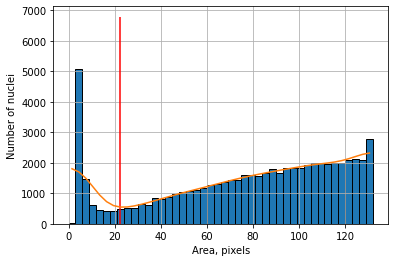

In [13]:
fig, ax = plt.subplots()
hist_left, bins_left, _ = ax.hist(mask_areas[mask_areas<main_peak],edgecolor='black', bins="fd")
kde = gaussian_filter1d(hist_left, sigma=bin_width/4)
centers = (bins_left[1:] + bins_left[:-1]) / 2
wells= find_peaks(-kde)[0]
thresh_small = centers[(wells).astype(int)][0]
ax.plot(centers, kde)
ax.vlines([thresh_small], 0, max(hist), colors=["r"])
decorate_areas_distr(fig, ax)

print("The threshold for small outliers is %1.2f pixels."%np.round(thresh_small))

Now we can cut off the outliers and look at the final distribution

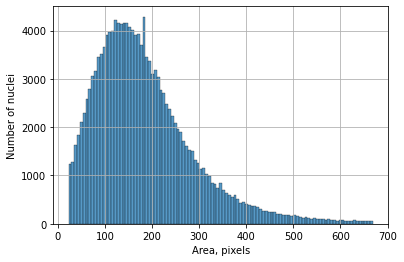

In [14]:
valid_ids = (mask_areas < thresh_big) * (mask_areas > thresh_small)
mask_areas_filtered = mask_areas[valid_ids]
fig, ax = plt.subplots()
sns.histplot(mask_areas_filtered, bins="rice",ax=ax)
decorate_areas_distr(fig,ax)

Makes sence to try other heuristics for bin width:

In [15]:
def pixels_to_mkm(x, tile_pixels_size=256, tile_phys_size = 100):
    return x * tile_phys_size / tile_pixels_size

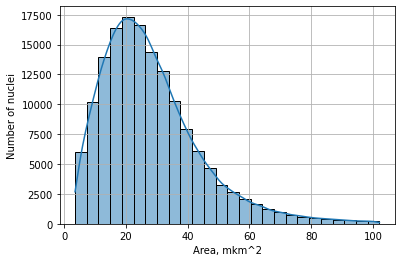

In [16]:
fig, ax = plt.subplots()
mask_areas_filtered_sqmkm = np.apply_along_axis(lambda x: pixels_to_mkm(pixels_to_mkm(x)), 0, mask_areas_filtered)
sns.histplot(mask_areas_filtered_sqmkm, bins="doane", ax=ax, kde=True)
decorate_areas_distr(fig,ax)
ax.set_xlabel("Area, mkm^2")
fig.savefig(os.path.join(IMGS_DIR, "final_areas_distr"), dpi=300)

Now we find a mean area and estimate the mean squire radius

In [17]:
mean_area = np.mean(mask_areas_filtered)
mean_raiduis = np.sqrt(mean_area / np.pi)
print("The mean square radius is %1.2f"%mean_raiduis)

The mean square radius is 7.67


In [18]:
yaml_dict = {
    "mean_radius": str(mean_raiduis),
    "thresh_small": str(thresh_small),
    "thresh_big": str(thresh_big)
}

with open(YAML_PATH, "w+") as file:
    yaml.safe_dump(yaml_dict, file)